Here, we check how the [Ilmatar Hybrid Power Plant](https://ilmatar.com/news/ilmatar-to-build-finlands-largest-renewable-energy-hybrid-park/) DVPP would operate

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Finnish Proudcion Data

In [3]:
df = pd.read_csv('../data/data_wind_solar_2024_25.csv', sep=';')
df.drop('endTime', inplace=True, axis=1)
df.rename(columns={'startTime': 'Datum'}, inplace=True)
df["Datum"] = pd.to_datetime(df["Datum"], format='mixed')
df.set_index('Datum', inplace=True)
df.columns = ['Wind', 'Solar']
df.head()

,Wind,Solar
Datum,,
2024-07-31 22:00:00+00:00,970.819,0.0
2024-07-31 22:15:00+00:00,968.006,0.0
2024-07-31 22:30:00+00:00,959.571,0.0
2024-07-31 22:45:00+00:00,902.011,0.0
2024-07-31 23:00:00+00:00,867.776,0.0


array([[<Axes: xlabel='Datum'>],
       [<Axes: xlabel='Datum'>]], dtype=object)

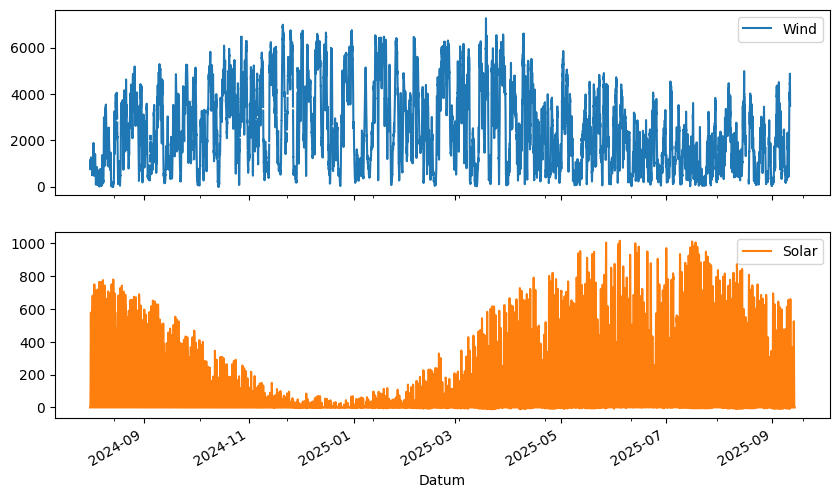

In [18]:
# plot
df.plot(subplots=True, layout=(2,1), figsize=(10,6))

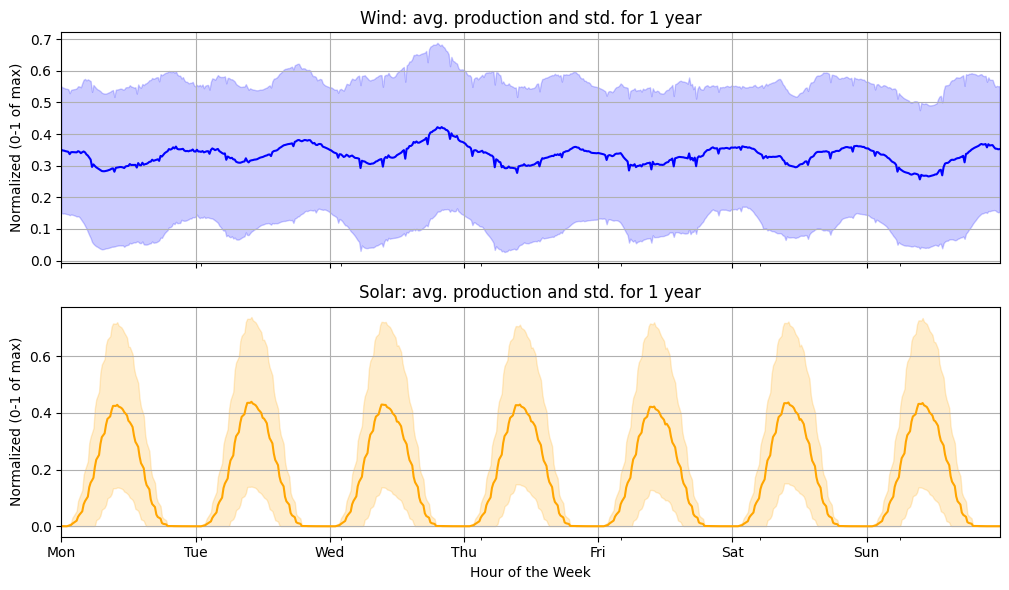

In [5]:
# create weekly profile by averaging for every time of the week and creating std
idxes = 24 * 7 * 4  # 15 min intervals
df_mean = df.groupby([df.index.dayofweek, df.index.hour, df.index.minute]).mean()
df_std = df.groupby([df.index.dayofweek, df.index.hour, df.index.minute]).std()
df_mean.index = pd.MultiIndex.from_tuples(df_mean.index, names=['Wochentag', 'Stunde', 'Minute'])
df_std.index = pd.MultiIndex.from_tuples(df_std.index, names=['Wochentag', 'Stunde', 'Minute'])

# normalize to max 1
max_vals = df.max()
df_mean = df_mean / max_vals
df_std = df_std / max_vals

df_mean_wind_solar = df_mean.copy() # save for later use

col1, col2 = df.columns

# plot mean with std as shaded area
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
df_mean[col1].plot(ax=ax[0], title='Wind: avg. production and std. for 1 year', color='b')
df_mean[col2].plot(ax=ax[1], title='Solar: avg. production and std. for 1 year', color='orange')
# add std as shaded area
ax[0].fill_between(np.arange(0, idxes), 
                   (df_mean[col1] - df_std[col1]).values.flatten(), 
                   (df_mean[col1] + df_std[col1]).values.flatten(), 
                   color='b', alpha=0.2)

lower = df_mean[col2] - df_std[col2]
lower[lower < 0] = 0
ax[1].fill_between(np.arange(0, idxes), 
                   lower.values.flatten(), 
                   (df_mean[col2] + df_std[col2]).values.flatten(), 
                   color='orange', alpha=0.2)

plt.xlabel('Hour of the Week')
# xticks: day + hour
plt.xticks(ticks=np.arange(0, idxes, idxes/7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlim(0, idxes-1)
plt.tight_layout()
ax[0].grid()
ax[1].grid()
ax[0].set_ylabel('Normalized (0-1 of max)')
ax[1].set_ylabel('Normalized (0-1 of max)')
plt.show()

## Ilmatar Hybrid Power Plant

### Plot average production

In [6]:
wind_cap = 216  # MW
solar_cap = 150  # MW
battery_cap, battery_energy = 25, 50  # MW, MWh

In [8]:
# plot a typical week of production with capacities in one plot
df_ilmatar = df_mean.copy()
df_ilmatar['Wind'] = df_ilmatar['Wind'] * wind_cap
df_ilmatar['Solar'] = df_ilmatar['Solar'] * solar_cap

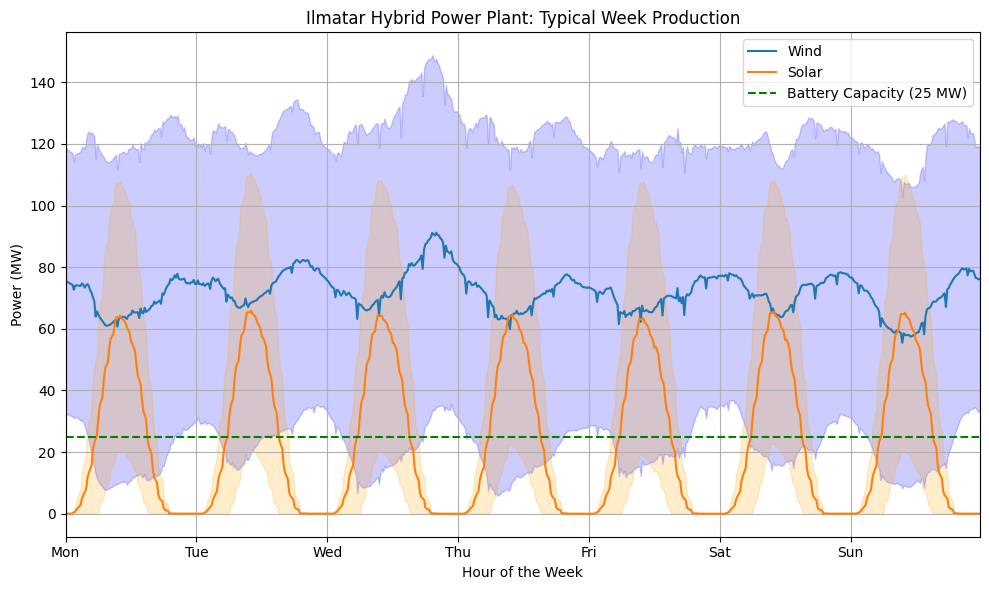

In [17]:
df_ilmatar.plot(figsize=(10,6), title='Ilmatar Hybrid Power Plant: Typical Week Production')
# plot battery as horizontal line
plt.axhline(y=battery_cap, color='g', linestyle='--', label='Battery Capacity (25 MW)')

# add std as shaded area
lower_wind = df_ilmatar['Wind'] - df_std['Wind'] * wind_cap
lower_wind[lower_wind < 0] = 0
plt.fill_between(np.arange(0, idxes), 
                 lower_wind.values.flatten(), 
                 (df_ilmatar['Wind'] + df_std['Wind'] * wind_cap).values.flatten(), 
                 color='b', alpha=0.2)
lower_solar = df_ilmatar['Solar'] - df_std['Solar'] * solar_cap
lower_solar[lower_solar < 0] = 0
plt.fill_between(np.arange(0, idxes), 
                 lower_solar.values.flatten(), 
                 (df_ilmatar['Solar'] + df_std['Solar'] * solar_cap).values.flatten(), 
                 color='orange', alpha=0.2)

plt.xlabel('Hour of the Week')
plt.ylabel('Power (MW)')
plt.xticks(ticks=np.arange(0, idxes, idxes/7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlim(0, idxes-1)
plt.tight_layout()
plt.legend()
plt.grid(True)

### check how much ancillary services can be supplied in a year

In [26]:
# how often can 50 MW be provided for 1 hour in a year?
thresh = 50  # MW
renewable_power = df['Wind'] * wind_cap / df['Wind'].max() + df['Solar'] * solar_cap / df['Solar'].max()
# average every hour
renewable_power = renewable_power.resample('h').mean()
renewable_power.dropna(inplace=True)

In [28]:
count = (renewable_power >= thresh).sum()
all_hours = renewable_power.shape[0] 
print(f'Renewable power >= {thresh} MW can be provided for {count} hours in a year.')
print(f'Total hours in a year: {all_hours}')
print(f'Percentage of hours: {count / all_hours * 100:.2f} %')

Renewable power >= 50 MW can be provided for 7479 hours in a year.
Total hours in a year: 9717
Percentage of hours: 76.97 %


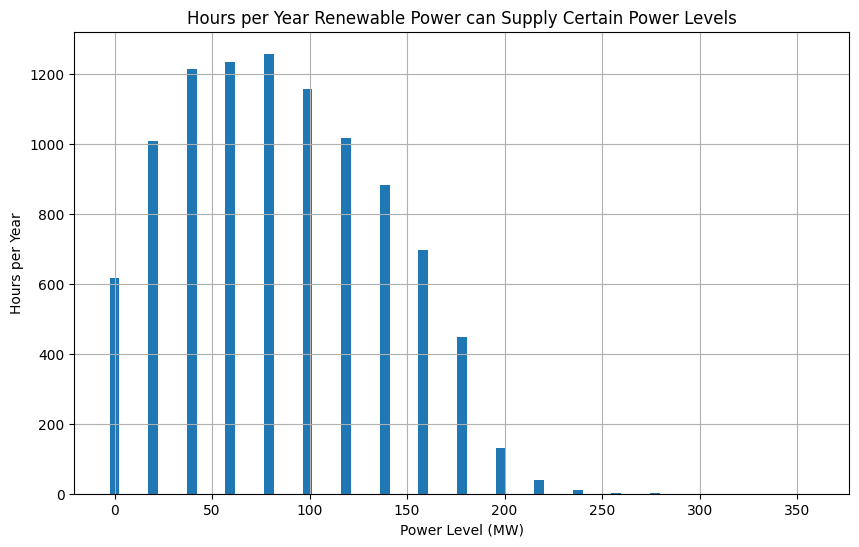

In [ ]:
# make bar plot of hours per year that can provide certain power levels
power_levels = np.linspace(0, wind_cap + solar_cap, 20)
hours_per_level = []
for k, level in enumerate(power_levels):
    if k == len(power_levels) - 1:
        break
    next_level = power_levels[k+1]
    hours = ((renewable_power >= level) & (renewable_power < next_level)).sum()
    hours_per_level.append(hours)

plt.figure(figsize=(10,6))
plt.bar(power_levels[:-1], hours_per_level, width=5)
plt.xlabel('Power Level (MW)')
plt.ylabel('Hours per Year')
plt.title('Hours per Year Renewable Power can Supply Certain Power Levels')
plt.grid(True)
plt.show()

Let's assume 1/10th of the plants capacity is reserved for anicallry services bidding.

In [ ]:
renewable_power_10pct = renewable_power * 0.1

Steps needed to run a full case study for the DVPP:
- choose a time frame, e.g. 1 month in winter, 1 month in summer
- get data:
    - DVPP size, production and forecast
    - price and procurement data
- make assumptions on battery operation
    - simple, robust: PV and Wind bid, battery jumps in for fast service and if forecast wrong
    - simple, risky: PV, Wind plus Battery bid
    - complex: optimize Battery based on forecast of renewable production, procurement and prices
- run simulation for DVPP with reward mechanism
- information to extract/outputs:
    - performance of DVPP
        - revenue, forecast vs. realized revenue
        - how did battery operate
    - game theoretic: reward split
        - how was reward split for single hours and for entire scenario
        - forecasted vs. realized reward
        - sanctions analysis: how often where there sanctions